In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
song = "FSDKaggle2018.audio_train/7fbb70f7.wav"
TRAIN_PATH =  "FSDKaggle2018.audio_train/"
ipd.Audio(TRAIN_PATH + "7fbb70f7.wav")

In [3]:
sample_rate, audio = wavfile.read(song)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 44100Hz
Audio duration: 7.44s


In [4]:
# print(audio)
time_ticks = np.linspace(0, len(audio) / sample_rate, num=len(audio))
print(time_ticks)

[0.00000000e+00 2.26758061e-05 4.53516121e-05 ... 7.43995465e+00
 7.43997732e+00 7.44000000e+00]


In [5]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio
audio = normalize_audio(audio)

In [6]:
def frame_audio(audio, window_size=2048, hop_size=10, sample_rate=44100):
    
    audio = np.pad(audio, int(window_size / 2), mode='constant', constant_values = (0))
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - window_size) / frame_len) + 1
    frames = np.zeros((frame_num,window_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+window_size]
    
    return frames

In [7]:
hop_size = 23
window_size = 2048

audio_framed = frame_audio(audio, window_size=window_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (324, 2048)


In [8]:
window = get_window("hann", window_size)

In [9]:
audio_win = audio_framed * window

In [12]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + window_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [11]:
# audio_winT = np.transpose(audio_win)

# audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

# for n in range(audio_fft.shape[1]):
#     audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

# audio_fft = np.transpose(audio_fft)

NameError: name 'FFT_size' is not defined

In [13]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(324, 1025)


In [14]:
np.shape(audio_fft)

(324, 1025)

In [15]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [16]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [17]:
def get_filter_points(fmin, fmax, mel_filter_num, window_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)
    
    return np.floor((window_size + 1) / sample_rate * freqs).astype(int), freqs

In [18]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, window_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([   0,   12,   28,   51,   82,  125,  184,  265,  376,  528,  737,
       1024])

In [19]:
def get_filters(filter_points, window_size):
    filters = np.zeros((len(filter_points)-2,int(window_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

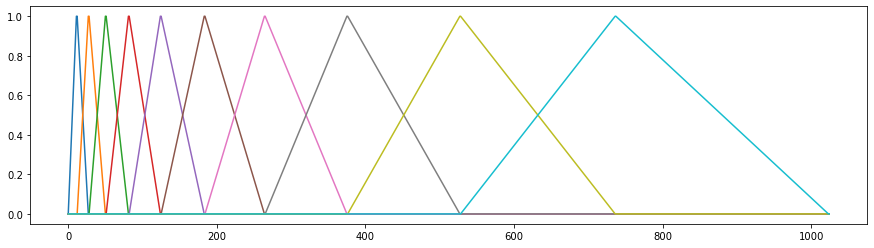

In [20]:
filters = get_filters(filter_points, window_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [21]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

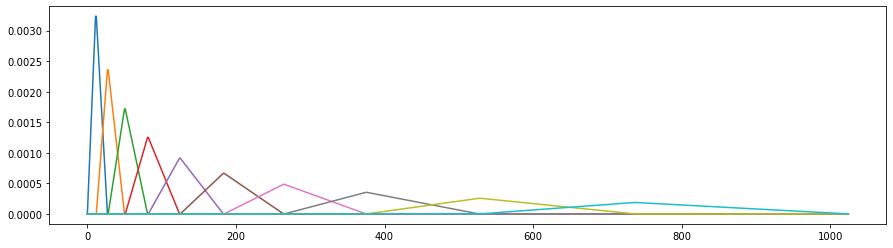

In [22]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [23]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 324)

In [24]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [25]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 324)

In [26]:
np.shape(cepstral_coefficents)

(40, 324)

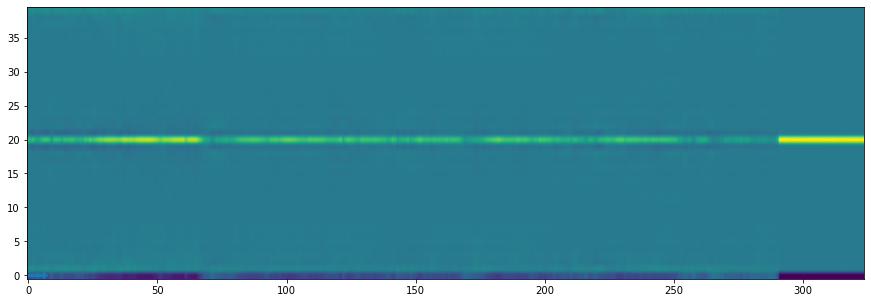

In [27]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

In [28]:
sample_rate, audio = wavfile.read(song)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 44100Hz
Audio duration: 7.44s


In [ ]:
hop_size = 1024
window_size = 2048
framed_audio = []

In [ ]:
def windowHann(signal, fr, windowSize):
    window = get_window("hann", windowSize)
    windowed = signal * window
    return windowed

def padSignal(signal, sr, windowSize, hopSize):
    signalLength = len(signal)
    numZeros = windowSize - (signalLength - math.floor(signalLength/hopSize)*hopSize);
    return np.concatenate((signal, np.zeros(numZeros)), axis=None)

In [ ]:
def process(signal, sr, windowSize, hopSize):
    origLength = len(signal)
    signal = padSignal(signal, sr, windowSize, hopSize)
    mfccArray = []
    for i in range(0, origLength, hopSize):
        toProcess = windowHann(signal[i: i+windowSize], sr, windowSize)
        framed_audio.append(toProcess)

In [ ]:
import math
process(audio, sample_rate, window_size, hop_size)

In [ ]:
audio

In [ ]:
framed_audio

In [ ]:
plt.plot(audio[:2048])

In [ ]:
plt.plot(framed_audio[0])

In [ ]:
import pywt
from pywt import dwt, wavedec

In [ ]:
cA2, cD2, cD1 =  wavedec(framed_audio[0], 'db32', mode='sym', level=2)

In [ ]:
len(cA2)

In [ ]:
len(cD2)

In [ ]:
len(cD1)